In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

from preprocess import diabetes_data

In [ ]:
!git clone https://github.com/suinleelab/path_explain.git

Cloning into 'path_explain'...
remote: Enumerating objects: 802, done.
remote: Counting objects: 100% (264/264), done.
remote: Compressing objects: 100% (195/195), done.
remote: Total 802 (delta 148), reused 163 (delta 69), pack-reused 538
Receiving objects: 100% (802/802), 207.47 MiB | 29.91 MiB/s, done.
Resolving deltas: 100% (381/381), done.


In [ ]:
from path_explain.path_explain.utils import set_up_environment
from path_explain.path_explain.plot.scatter import scatter_plot
from path_explain.path_explain.plot.summary import summary_plot
from path_explain.path_explain.explainers.path_explainer_torch import PathExplainerTorch

In [ ]:
set_up_environment(visible_devices='3')
x_train, y_train, x_test, y_test, feature_names, x_train_un, x_test_un = diabetes_data()

In [ ]:
class DiabetesData(Dataset):

  def __init__(self, X, y):
    self.X = X
    self.y = y
  
  def __len__(self):
    return len(self.y)
  
  def __getitem__(self, idx):
    
    feature = torch.from_numpy(self.X[idx])
    label = torch.from_numpy(np.asarray(self.y[idx]))
    label = label.float()
    
    return feature, label

In [ ]:
train_ds = DiabetesData(x_train, y_train)
test_ds = DiabetesData(x_test, y_test)

train_loader = DataLoader(train_ds, batch_size=200, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=50, shuffle=True)

In [ ]:
class NaiveNet(nn.Module):

  def __init__(self):
    super(NaiveNet, self).__init__()

    self.mlp = nn.Sequential(
        nn.Linear(16, 128),
        nn.Softplus(),
        nn.Linear(128, 64),
        nn.Softplus(),
        nn.Linear(64, 1)
    )

  def forward(self, input):
    return torch.sigmoid(self.mlp(input))

model = NaiveNet()

In [ ]:
print(model)

NaiveNet(
  (mlp): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
loss_fn = nn.BCELoss()

In [ ]:
def train(model, optimizer, loss_fn):

  for epoch in range(250):
    running_loss = 0.0
    for batch_idx, (feature, label) in enumerate(train_loader):

      optimizer.zero_grad()
      predictions = model.forward(feature)
      loss = loss_fn(predictions, label.float().unsqueeze(1))

      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      if epoch%50 == 0:
        print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_idx+1, running_loss / 50))
        running_loss = 0.0
  print('Trained!')
      

In [ ]:
def test(model, loss_fn):
  for batch_idx, (feature, label) in enumerate(test_loader):

    predictions = model.forward(feature)
    loss = loss_fn(predictions, label.unsqueeze(1))
    pred_thresh = (predictions > 0.5).float()
    correct = (pred_thresh == label).sum()
    print('Accuracy : %.5f '%(correct/len(label)), 'Loss: %.5f'%(loss.item()))

In [ ]:
explainer = PathExplainerTorch(model)

In [ ]:
x_train_tensor = torch.from_numpy(x_train)
x_test_tensor = torch.from_numpy(x_test)
all_data = torch.cat([x_train_tensor, x_test_tensor], axis=0)

In [ ]:
all_data.requires_grad = True

In [ ]:
attributions = explainer.attributions(input_tensor=all_data,
                                      baseline=x_train_tensor,
                                      num_samples = 200,
                                      use_expectation=True,
                                      output_indices = 0
                                      )

In [ ]:
interactions = explainer.interactions(input_tensor = all_data,
                                      baseline=x_train_tensor,
                                      num_samples=200,
                                      use_expectation=True,
                                      output_indices=0,
                                      verbose=True)

100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


In [ ]:
all_data_renorm = np.concatenate([x_train_un, x_test_un])

array([[68,  1,  1, ...,  0,  0,  0],
       [48,  1,  1, ...,  0,  1,  0],
       [53,  1,  0, ...,  1,  1,  0],
       ...,
       [67,  1,  1, ...,  1,  0,  1],
       [38,  1,  0, ...,  0,  0,  0],
       [40,  1,  0, ...,  1,  0,  1]])

In [ ]:
attributions_np = attributions.detach().numpy()
interactions_np = interactions.detach().numpy()

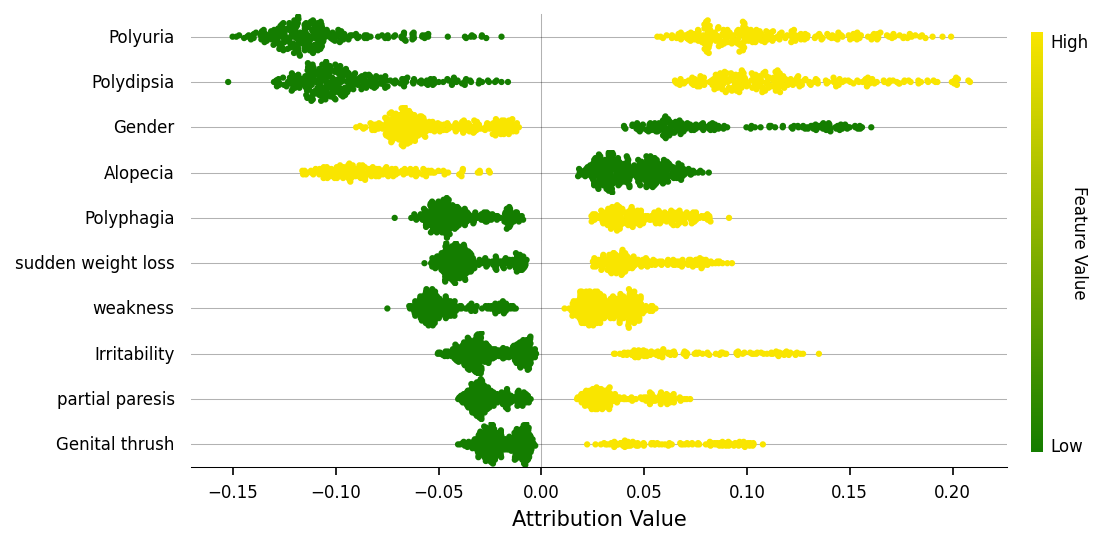

In [ ]:
summary_plot(attributions_np,
             all_data_renorm,
             interactions=None,
             interaction_feature=None,
             feature_names=feature_names,
             plot_top_k=10)

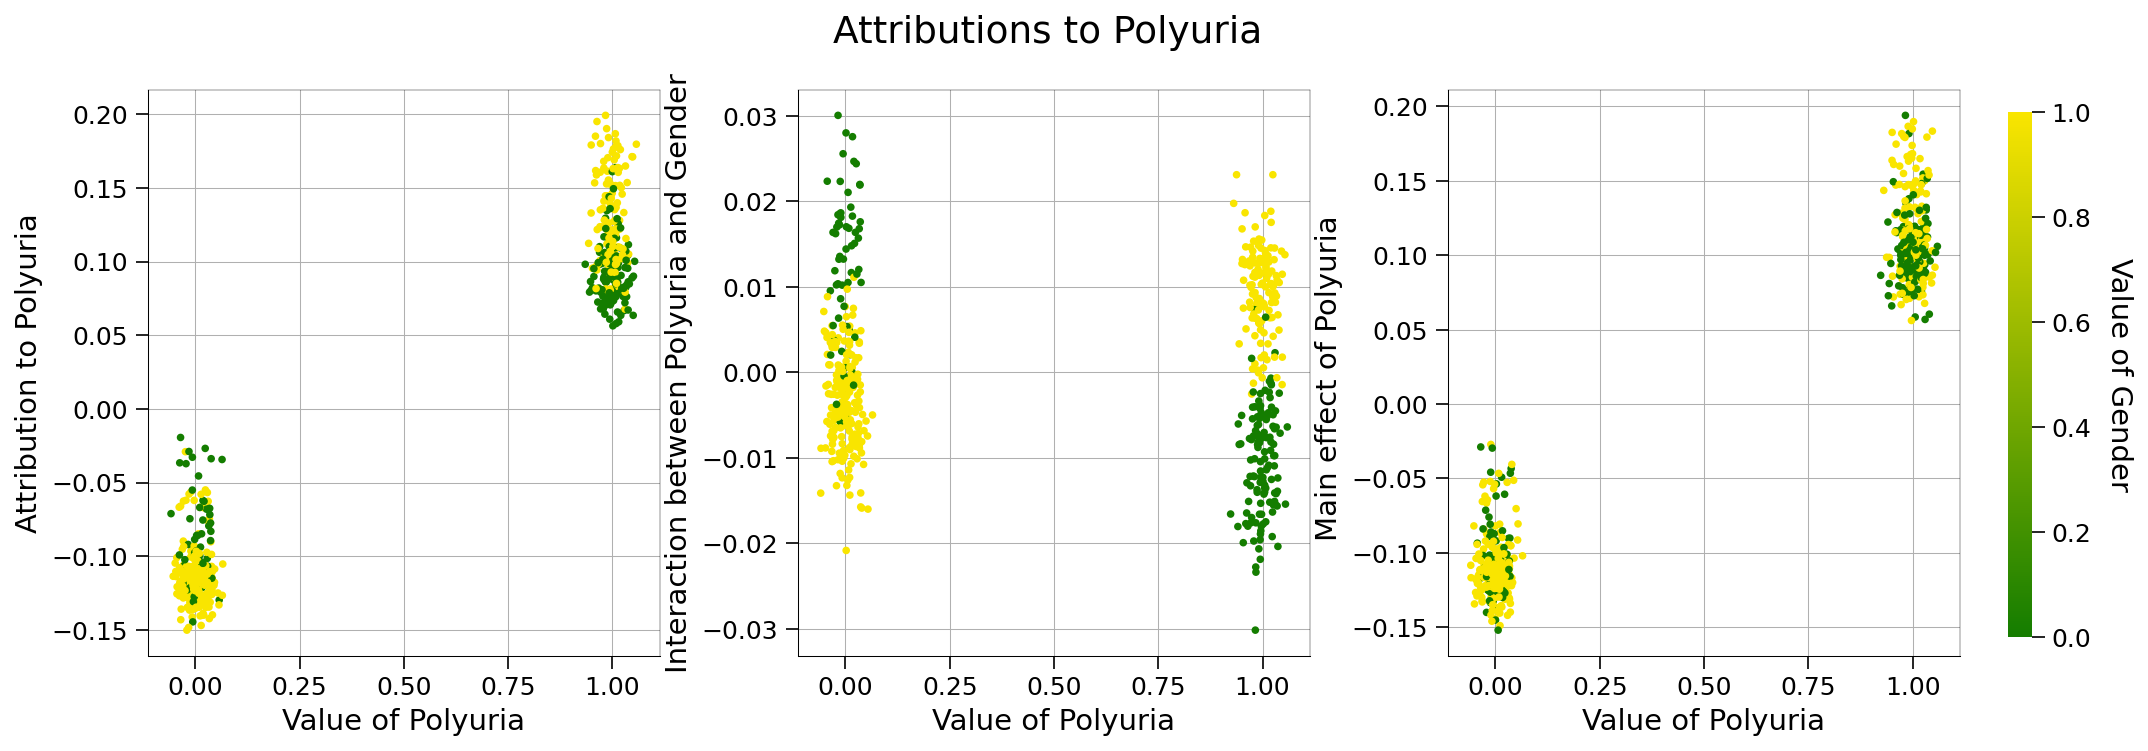

In [ ]:
fig, axs = scatter_plot(attributions_np,
                        all_data_renorm,
                        feature_index='Polyuria',
                        interactions=interactions_np,
                        color_by='Gender',
                        feature_names=feature_names,
                        scale_y_ind=True,
                        add_random_noise_x=True)

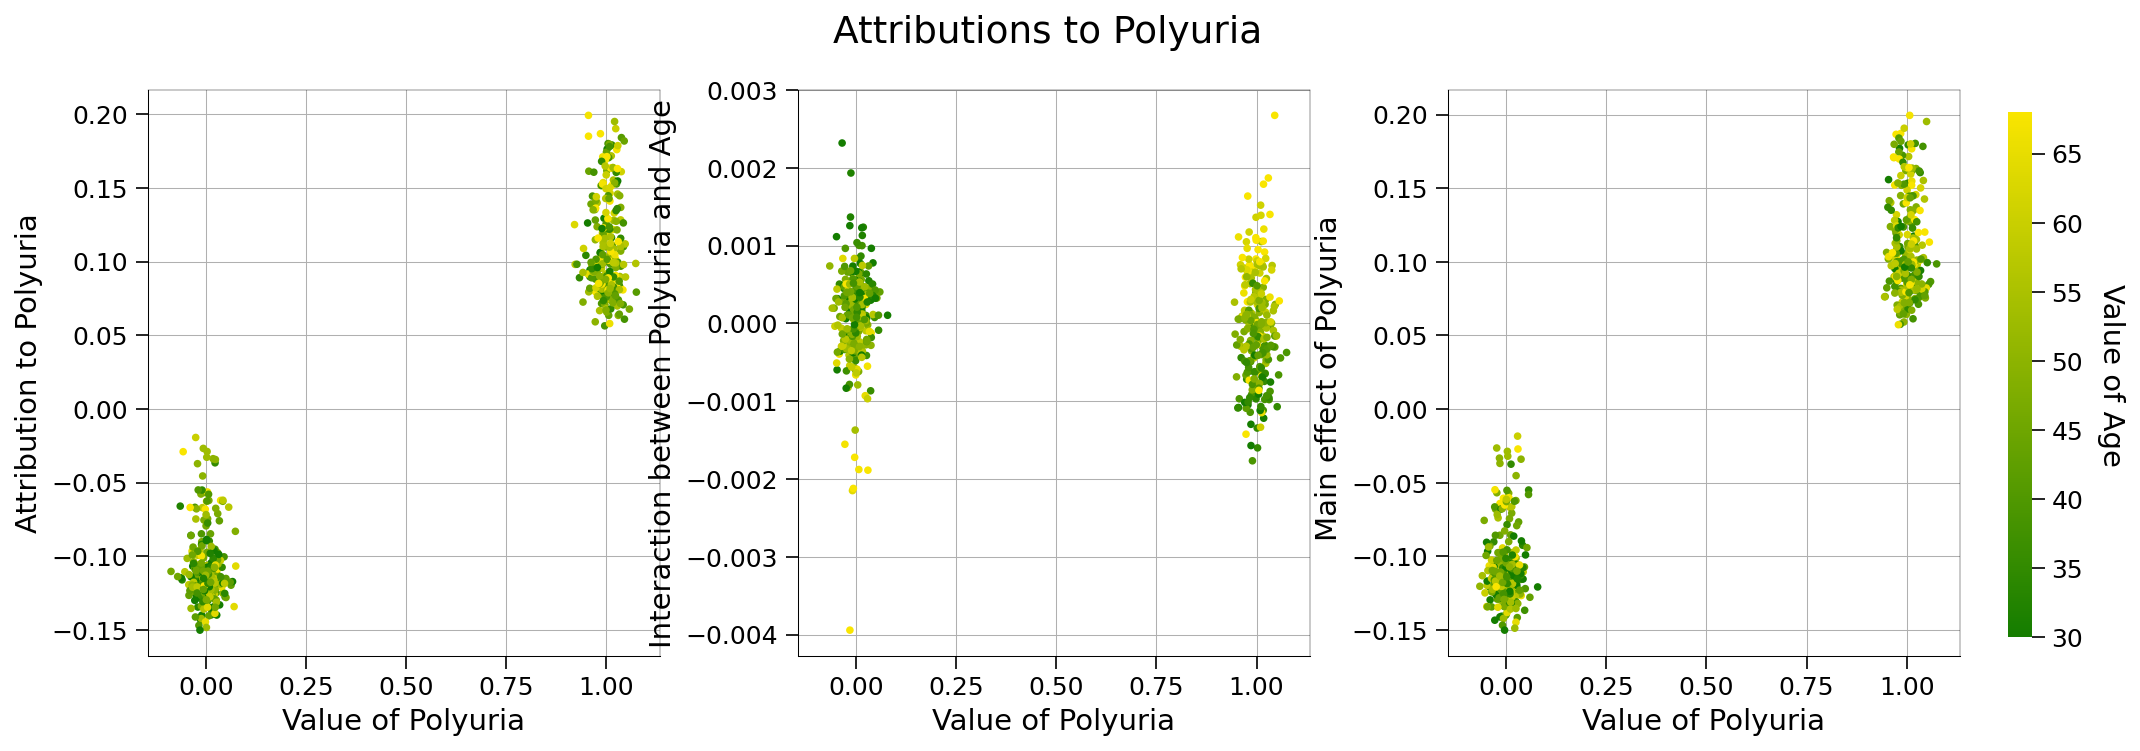

In [ ]:
fig, axs = scatter_plot(attributions_np,
                        all_data_renorm,
                        feature_index='Polyuria',
                        interactions=interactions_np,
                        color_by='Age',
                        feature_names=feature_names,
                        scale_y_ind=True,
                        add_random_noise_x=True)

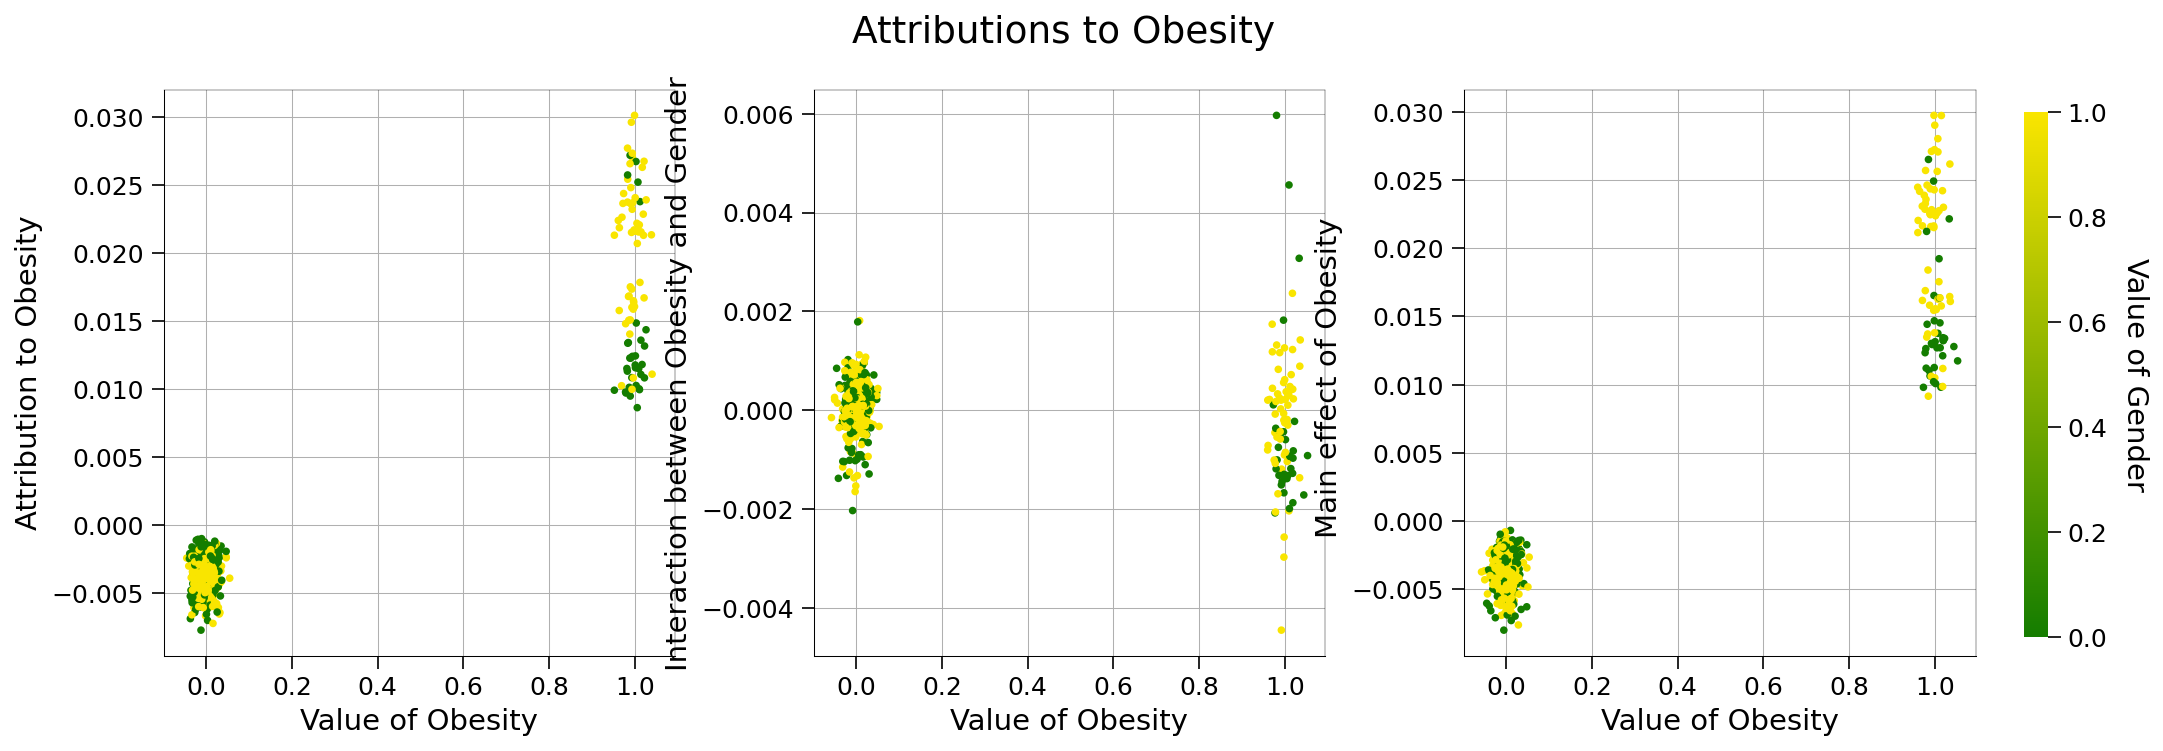

In [ ]:
fig, axs = scatter_plot(attributions_np,
                        all_data_renorm,
                        feature_index='Obesity',
                        interactions=interactions_np,
                        color_by='Gender',
                        feature_names=feature_names,
                        scale_y_ind=True,
                        add_random_noise_x=True)